In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np
import optuna
import operator
import joblib
import cv2
import os

# 2. Classification

<h1>Extract Feature </h1>

In [2]:
def extract_hog_feature(image):
    features, hog_image = hog(image, orientations=11, pixels_per_cell=(6, 6),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=True)
    return features, hog_image

In [3]:
def hog_show(image, hog_image):
    # Hiển thị ảnh gốc và ảnh HOG
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(image, cmap='gray')

    plt.subplot(1,2,2)
    plt.title("HOG Features")
    plt.imshow(hog_image, cmap='gray')

    plt.show()

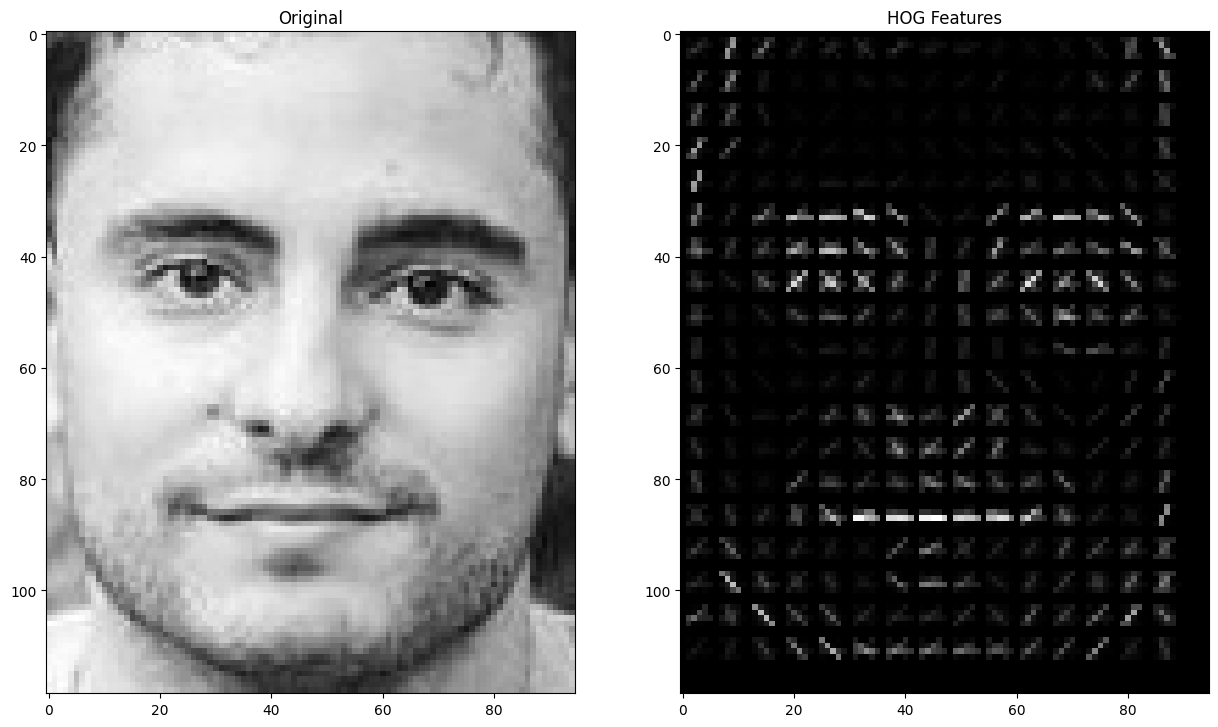

In [4]:
path = 'Dataset/TrainDetection/TrainClassification/Positive/00000005_crop_1.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, hog_image = extract_hog_feature(img)
hog_show(img, hog_image)

In [5]:
def load_hog_data(input_folder):
    data = []
    label = []
    file_paths = []
    for idx, cls_name in enumerate(os.listdir(input_folder)):
        class_path = os.path.join(input_folder, cls_name)
        if os.listdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if file_path.lower().endswith(('jpg', 'png')):
                    image = cv2.imread(file_path)
                    if image is None:
                        continue
                    image = cv2.resize(image, (72,72))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    feature, _ = extract_hog_feature(image)
                    file_paths.append(file_path)
                    data.append(feature)
                    label.append(idx)
                    
    return np.array(data), np.array(label), file_paths

In [18]:
train_dir = 'Dataset/TrainDetection/TrainClassification'
test_dir = 'Dataset/TrainDetection/TestClassification'

X_train, y_train, file_train = load_hog_data(train_dir)
X_test, y_test, file_test = load_hog_data(test_dir)

In [19]:
print(f"Kich thuoc tap du lieu: Train: ({X_train.shape}, {y_train.shape}); Test: ({X_test.shape}, {y_test.shape})")

Kich thuoc tap du lieu: Train: ((7987, 5324), (7987,)); Test: ((1535, 5324), (1535,))


<h1> Training

<h2> Train and Test Classification Model

In [20]:
svm = SVC(kernel='poly', C = 100, gamma = 1, degree = 4, probability = True, class_weight='balanced')
print("Traning..............")
svm.fit(X_train, y_train)
print("Testing..............")
y_pred = svm.predict(X_test)
print("Train/ Test done!....")

Traning..............
Testing..............
Train/ Test done!....


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       969
           1       1.00      1.00      1.00       566

    accuracy                           1.00      1535
   macro avg       1.00      1.00      1.00      1535
weighted avg       1.00      1.00      1.00      1535



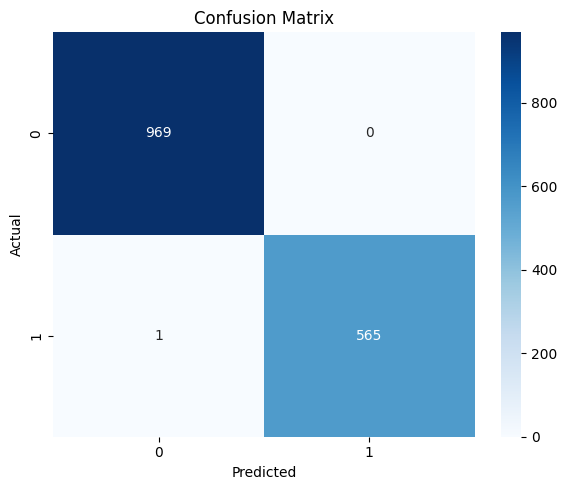

In [21]:
# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Hiển thị với seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Dataset/TrainDetection/TestClassification\Positive\ky-yeu-cap-1-1-scaled_crop_8.jpg


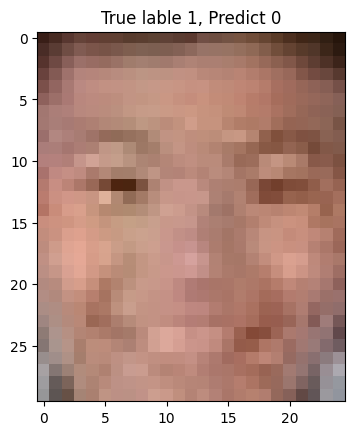

In [22]:
misclassified_indexes = [i for i in range(len(y_pred)) if y_pred[i] != y_test[i]]

for i in misclassified_indexes:
    source = file_test[i]
    print(source)
    img = cv2.imread(source)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"True lable {y_test[i]}, Predict {y_pred[i]}")
    plt.show()

In [23]:
joblib.dump(svm, 'HOG_SVM.pkl')

['HOG_SVM.pkl']

# 3. Detection

In [24]:
model = joblib.load('HOG_SVM.pkl')

In [25]:
import imutils
def pyramid(image, scale=1.5, minSize=(72, 72)):    
    yield image 

    while True:
        w = int(image.shape[1] / scale)     
        image = imutils.resize(image, width=w) 
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break 

        yield image

In [26]:
def find_bounding_boxes(image):
    (winW, winH) = (72, 72)
    (blockW, blockH) = (11, 11)
    boxes = []
    current_scale = 1.0
    scale = 1.5
    step = 1

    for resized in pyramid(image, scale):
        # Tính hog cho toàn ảnh
        hog_map = hog(resized, orientations=11, pixels_per_cell=(6, 6),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize= False, feature_vector = False)
        hog_map = hog_map.reshape(hog_map.shape[0], hog_map.shape[1], -1)
        step = 1  
        h, w, d = hog_map.shape #(n_blocks_row, n_blocks_col, orientations * cells_per_block[0] * cells_per_block[1])
        
        for i in range(0, h - blockH + 1, step):
            for j in range(0, w - blockW + 1, step):
                window_feat = hog_map[i:i+blockW, j:j+blockH, :].copy()
                if (window_feat.shape[:2] != (11,11)):
                    continue

                f = window_feat.flatten()
                f = f.reshape(1, -1)
                pred = model.predict(f)[0]
                proba = model.predict_proba(f)[0][pred]
                if pred == 1 and proba > 0.9:
                    x, y = j*6, i*6
                    (orig_x1, orig_y1) = (int(x * current_scale), int(y * current_scale))
                    (orig_x2, orig_y2) = (int((x + winW) * current_scale), int((y + winH) * current_scale))
                    boxes.append((orig_x1, orig_y1, orig_x2, orig_y2, proba)) # xmin, ymin, xmax, ymax, proba
        # Tính lại current_scale
        current_scale *= scale
    return boxes

In [27]:
def non_max_suppression(boxes, overlapThresh=0.3):
    # Chuyển đổi các bounding box thành numpy array
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    # Tính toán diện tích của các bounding box
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sắp xếp các bounding box theo thứ tự giảm dần của xác suất
    idxs = np.argsort(boxes[:, 4])[::-1]

    pick = []

    while len(idxs) > 0:
        # Lấy chỉ số của bounding box đầu tiên trong danh sách đã sắp xếp (xác suất cao nhất)
        i = idxs[0]
        pick.append(i)

        # Tính toán tọa độ giao nhau giữa các bounding box.
        # Kết quả là một mảng xx1 có kích thước bằng len(idxs[1:]), chứa tọa độ x bắt đầu của vùng giao nhau giữa box i và mỗi box còn lại.
        # Tương tự ta sẽ có 4 mảng.
        xx1 = np.maximum(x1[i], x1[idxs[1:]]) 
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        # Tính toán chiều rộng và chiều cao của giao nhau
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Tính toán tỷ lệ giao nhau
        overlap = (w * h) / area[idxs[1:]]  # sau này phải +1 để lấy index đúng trong idxs và area

        # Loại bounding box lớn hơn khi nó hoàn toàn bao phủ bounding box hiện tại
        contain_mask = (
            (x1[i] >= x1[idxs[1:]]) & (y1[i] >= y1[idxs[1:]]) &
            (x2[i] <= x2[idxs[1:]]) & (y2[i] <= y2[idxs[1:]])
        )
        
        # Xóa các bounding box có tỷ lệ giao nhau lớn hơn overlapThresh
        idxs = np.delete(idxs, np.concatenate(([0], np.where((overlap > overlapThresh)|contain_mask)[0] + 1)))
    # Cuối cùng, các bdb còn lại trong danh sách pick là các bdb không bị xóa, tức là không có tỷ lệ giao nhau lớn hơn overlapThresh.
    return boxes[pick]

In [28]:
def draw_boxes(image, boxes):
    for (x1, y1, x2, y2, proba) in boxes:
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)
        proba = float(proba)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"{proba:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

In [29]:
def detect_faces(image_path):
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    # Chỉ resize ảnh nếu có kích thước quá lớn để đảm bảo thời gian cũng như độ chính xác
    h, w = image.shape[:2]
    if(h>=1200 or w >= 1200):
        if(w > h):
            image = imutils.resize(image, width=1200)
        else:
            image = imutils.resize(image, height=1200)
        h, w = image.shape[:2]

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Chuyển đổi sang ảnh xám
    # Tìm các bounding box
    boxes = find_bounding_boxes(gray_image)
    # Áp dụng non-max suppression để loại bỏ các bounding box trùng lặp
    boxes = non_max_suppression(boxes, overlapThresh=0.1)
    # Vẽ các bounding box lên ảnh
    final_image = draw_boxes(image, boxes)
    #return final_image, boxes, w, h
    return final_image, boxes, w, h

In [30]:
import xml.etree.ElementTree as ET

def parse_and_scale_voc_xml(xml_file, w_new, h_new):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Lấy kích thước gốc từ file XML
    size = root.find('size')
    w_orig = int(size.find('width').text)
    h_orig = int(size.find('height').text)

    scale_x = w_new / w_orig
    scale_y = h_new / h_orig

    boxes = []

    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        x_min = int(float(bbox.find('xmin').text))
        y_min = int(float(bbox.find('ymin').text))
        x_max = int(float(bbox.find('xmax').text))
        y_max = int(float(bbox.find('ymax').text))

        # Scale bbox theo kích thước ảnh mới
        x_min = int(x_min * scale_x)
        x_max = int(x_max * scale_x)
        y_min = int(y_min * scale_y)
        y_max = int(y_max * scale_y)

        boxes.append((x_min, y_min, x_max, y_max))
    
    return boxes


In [31]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)  # tránh chia 0
    return iou


<h1> Test single image

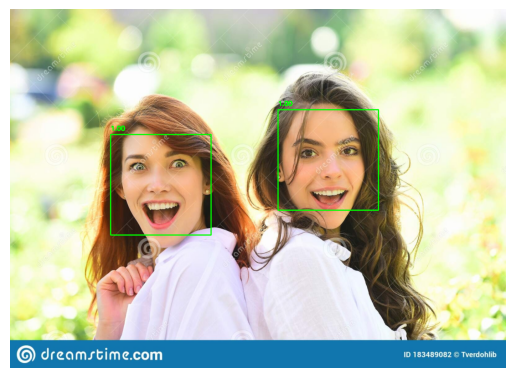

In [32]:
image_path = 'Dataset/TrainDetection/00000026.jpg'
output_image, _, _, _ = detect_faces(image_path)
if output_image is not None:
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()